In [1]:
import time
import numpy as np
import xarray as xr
import glob, os
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
%matplotlib inline

In [13]:
PHASE = 'Summer'
# PHASE = 'Winter'

# Specify regions
if PHASE == 'Summer':
    start_date = '2016-08-10T00'
    end_date = '2016-09-10T00'
    lon_bounds = [-180, 180]
    lat_bounds = [-15, 30]
if PHASE == 'Winter':
    start_date = '2020-02-01T00'
    end_date = '2020-03-01T00'
    lon_bounds = [-180, 180]
    lat_bounds = [-20, 15]
    
dir_in = f'/pscratch/sd/f/feng045/DYAMOND/{PHASE}/OBS/intqv/'
basename_hoaps = 'hoaps-c.r30.h06.wvpa.'

files_in = sorted(glob.glob(f'{dir_in}{basename_hoaps}*.nc'))
print(f'Number of HOAPS files {len(files_in)}')
print(files_in)

dir_out = f'/pscratch/sd/f/feng045/DYAMOND/{PHASE}/OBS/envs/'
out_filename_timeseries = f'{dir_out}{PHASE}_HOAPS_intqv_timeseries.nc'
out_filename_map = f'{dir_out}{PHASE}_HOAPS_intqv_map.nc'

Number of HOAPS files 2
['/pscratch/sd/f/feng045/DYAMOND/Summer/OBS/intqv/hoaps-c.r30.h06.wvpa.2016-08.nc', '/pscratch/sd/f/feng045/DYAMOND/Summer/OBS/intqv/hoaps-c.r30.h06.wvpa.2016-09.nc']


In [3]:
# Read and combine input files
ds_in = xr.open_mfdataset(files_in, combine='nested', concat_dim='time')
# Reverse lat coordinate so it starts from south to north
ds_in = ds_in.reindex({'lat':list(reversed(ds_in['lat']))})
ds_in

<xarray.Dataset>
Dimensions:    (time: 244, lat: 320, lon: 720, nv: 2)
Coordinates:
  * time       (time) datetime64[ns] 2016-08-01 ... 2016-09-30T18:00:00
  * lat        (lat) float64 -79.75 -79.25 -78.75 -78.25 ... 78.75 79.25 79.75
  * lon        (lon) float64 -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
Dimensions without coordinates: nv
Data variables:
    time_bnds  (time, nv) datetime64[ns] dask.array<chunksize=(124, 2), meta=np.ndarray>
    wvpa       (time, lat, lon) float32 dask.array<chunksize=(124, 320, 720), meta=np.ndarray>
    dtime      (time, lat, lon) timedelta64[ns] dask.array<chunksize=(124, 320, 720), meta=np.ndarray>
    numo       (time, lat, lon) float64 dask.array<chunksize=(124, 320, 720), meta=np.ndarray>
    satm       (time, lat, lon) int32 dask.array<chunksize=(124, 320, 720), meta=np.ndarray>
Attributes: (12/48)
    Conventions:                 CF-1.7,ACDD-1.3
    title:                       ECV Water vapour - Total Column Water Vapour
    summary:                     This dataset contains gridded Interim Climat...
    netcdf_library_version:      4.7.3 of Jan 28 2020 12:58:11 $
    institution:                 Deutscher Wetterdienst (DWD)
    project:                     Copernicus Climate Change Service (C3S), C3S...
    ...                          ...
    instrument_vocabulary:       GCMD Instruments, Version 8.1
    date_created:                2020-09-16T08:38:39 UTC
    date_modified:               2020-09-16T08:38:39 UTC
    history:                     2020-09-16T08:38:39 UTC: hoaps_composite -n ...
    platform:                    DMSP 5D-3/F16 > Defense Meteorological Satel...
    instrument:                  SSMIS > Special Sensor Microwave Imager/Sounder

In [4]:
# Average within specified region to get time series
intqv_avg_timeseries = ds_in['wvpa'].sel(
    lon=slice(lon_bounds[0], lon_bounds[1]), 
    lat=slice(lat_bounds[0], lat_bounds[1]),
).mean(dim=('lat','lon'), keep_attrs=True)

In [5]:
# Further average to daily
intqv_daily = intqv_avg_timeseries.resample(time='1D').mean(keep_attrs=True).compute()
intqv_daily

<xarray.DataArray 'wvpa' (time: 61)>
array([44.613613, 44.423332, 44.373787, 44.301723, 43.860004, 43.40274 ,
       43.5194  , 43.535286, 43.50278 , 43.70141 , 43.73707 , 43.825096,
       43.795902, 44.19256 , 43.92196 , 43.713367, 43.645664, 43.93624 ,
       44.379295, 44.30828 , 44.53181 , 45.000217, 44.75038 , 44.194878,
       44.127754, 44.14973 , 44.060555, 44.720955, 44.82411 , 44.97295 ,
       44.69981 , 44.513985, 44.408943, 44.051674, 43.568233, 43.876   ,
       43.712612, 44.12255 , 44.80258 , 44.094738, 44.36946 , 44.76321 ,
       44.48575 , 44.154793, 44.47376 , 44.704483, 44.133453, 44.110935,
       44.31847 , 44.748894, 44.875793, 44.53968 , 44.64711 , 44.250565,
       44.29208 , 43.643814, 43.496475, 42.96937 , 42.707535, 42.79281 ,
       43.39003 ], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2016-08-01 2016-08-02 ... 2016-09-30
Attributes:
    long_name:       Water Vapor Path
    standard_name:   atmosphere_water_vapor_content
    units:           kg/m^2
    C_format:        %6.2f
    FORTRAN_format:  F6.2
    comment:         1D-Var: Algorithm Theoretical Baseline Document HOAPS ve...
    cell_methods:    area: mean
    code:            3

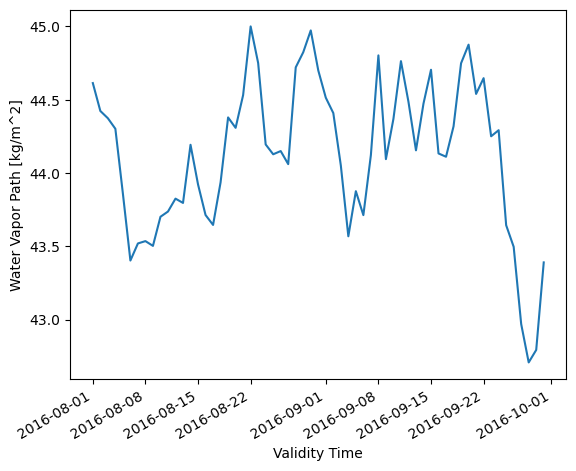

In [6]:
intqv_daily.plot()

In [7]:
# Average between specified time period
# print(f'Calculating temporal average ...')
intqv_avg_map = ds_in['wvpa'].sel(time=slice(start_date, end_date)).mean(dim='time', keep_attrs=True)

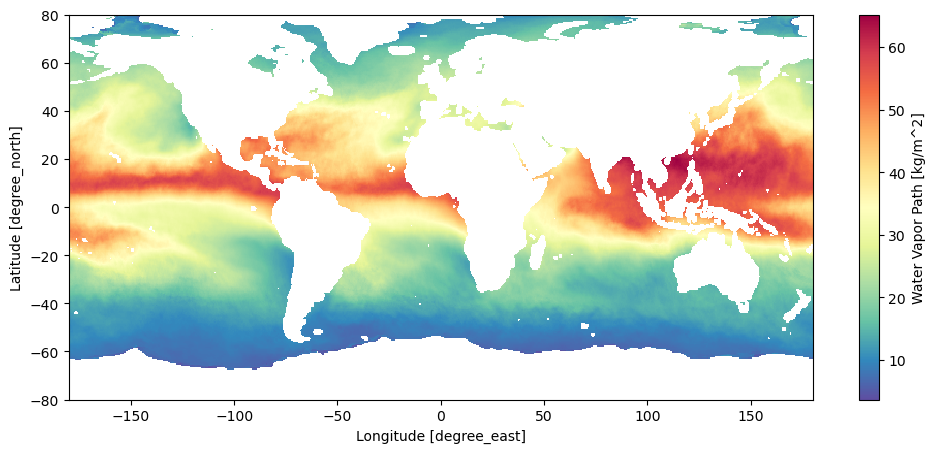

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(12,5), dpi=100)
intqv_avg_map.plot(cmap='Spectral_r', ax=ax)

In [9]:
out_filename_timeseries

'/pscratch/sd/f/feng045/DYAMOND/Summer/OBS/envs/Summer_HOAPS_intqv_timeseries.nc'

In [10]:
#-------------------------------------------------------------------------
# Write output time series file
#-------------------------------------------------------------------------
var_dict = {
    'intqv': (['time'], intqv_daily.data),
}
coord_dict = {
    'time': (['time'], intqv_daily.time.data),
}
gattr_dict = {
    'title': f'Mean intqv time series from HOAPS',
    'contact':'Zhe Feng, zhe.feng@pnnl.gov',
    'lon_bounds': lon_bounds,
    'lat_bounds': lat_bounds,
    'created_on':time.ctime(time.time()),
}
dsout = xr.Dataset(var_dict, coords=coord_dict, attrs=gattr_dict)

fillvalue = np.nan
# Set encoding/compression for all variables
comp = dict(zlib=True, _FillValue=fillvalue)
encoding = {var: comp for var in dsout.data_vars}
dsout.to_netcdf(path=out_filename_timeseries, mode='w', format='NETCDF4', unlimited_dims='time', encoding=encoding)
print(f'Time series saved: {out_filename_timeseries}')

Time series saved: /pscratch/sd/f/feng045/DYAMOND/Summer/OBS/envs/Summer_HOAPS_intqv_timeseries.nc


In [11]:
out_filename_map

'/pscratch/sd/f/feng045/DYAMOND/Summer/OBS/envs/Summer_HOAPS_intqv_map.nc'

In [12]:
#-------------------------------------------------------------------------
# Write output map file
#-------------------------------------------------------------------------
var_dict = {
    'intqv': (['lat', 'lon'], intqv_avg_map.data),
}
coord_dict = {
    'lat': (['lat'], ds_in.lat.data, ds_in.lat.attrs),
    'lon': (['lon'], ds_in.lon.data, ds_in.lon.attrs),
}
gattr_dict = {
    'title': f'Time mean intqv map from HOAPS',
    'contact':'Zhe Feng, zhe.feng@pnnl.gov',
    'start_date': start_date,
    'end_date': end_date,
    'created_on':time.ctime(time.time()),
}
dsout = xr.Dataset(var_dict, coords=coord_dict, attrs=gattr_dict)
fillvalue = np.nan
# Set encoding/compression for all variables
comp = dict(zlib=True, _FillValue=fillvalue, dtype='float32')
encoding = {var: comp for var in dsout.data_vars}

dsout.to_netcdf(path=out_filename_map, mode='w', format='NETCDF4', encoding=encoding)
print(f'Map saved: {out_filename_map}')

Map saved: /pscratch/sd/f/feng045/DYAMOND/Summer/OBS/envs/Summer_HOAPS_intqv_map.nc
